In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))
print(root_dir)

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme


In [2]:
import pprint

import numpy as np
from matplotlib import pyplot as plt
from inference.BayesModel import BayesModel
from inference.HierarchicalBayesModel import prior_structure, norm_ppf, halfnorm_ppf
from inference.network import Network
from empirical.create_surrogate_data import SurrogateData
from inference.NestedSamplingMethods import run_sampling, plot_results


# Generate data
* create 2 population network (inhib/exc) without mixed synapses
* ensure constant structure parameters ($\varepsilon$, $\eta$, $\tau_{1,2}$) while others may ($\alpha_{0_{1,2}}$) or should ($\bar{\nu}_{1,2}$) vary
* drive with different input currents (balance equation -> nu_bar), assume constant drive to all

In [12]:
def create_data_from_params(ground_truth_params,N=1000,T=120,plot=False):
    net = Network(**{key: ground_truth_params[key] for key in ["eps", "eta"]})
    for p,pop in enumerate(ground_truth_params["distr"]):
        net.register_population(p,**{key: pop[key] for key in ["nu_bar", "alpha_0", "J0"]})

        for s,syn in enumerate(pop["synapses"]):
            net.populations[p].register_synapse(s, **{key: syn[key] for key in ["tau_I"]})
    net.set_weights()
    net.calculate_sigma_V()
    net.solve_selfcon()

    ref_values = {
        "distr": net.export_distr(),
        # "distr": [
        #     distr_params(gamma=2.1, delta=4., nu_max=25.0,kappa=4.),
        #     distr_params(gamma=1.5, delta=4.5, nu_max=25.0,kappa=1.),
        #     # distr_params(gamma=1.9, delta=3.5, nu_max=25.0,kappa=1.),
        # ],
        "join": False,
        "N": N,
        "T": T,
    }

    SD = SurrogateData(N=ref_values["N"],T=ref_values["T"],n_animals=1)
    SD.artificial_data(ref_values,plot=False)
    if plot:
        SD.plot_rates()

    return SD, net

In [13]:
def define_biological_prior(n_conditions):
    def bounded_flat(x,low,high):
        return x*(high-low)+low

    prior = {}
    prior["eps"] = prior_structure(bounded_flat, low=0.0, high=np.sqrt(1./2), label="$\\epsilon$")
    prior["eta"] = prior_structure(bounded_flat, low=0.0, high=1.0, label="$\\eta$")

    for p in range(2):
        prior[f"nu_bar_pop{p}"] = prior_structure(
            halfnorm_ppf, loc=0.0, scale=5.0,
            # norm_ppf,
            # mean=prior_structure(halfnorm_ppf, loc=0.0, scale=5.0),
            # sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=1.),
            # shape=(n_conditions,) if p==1 else (1,),
            shape=(n_conditions,),
            label="$\\bar{\\nu}_"+str(p)+"$"
        )

        prior[f"alpha_0_pop{p}"] = prior_structure(
            halfnorm_ppf,loc=0.0,scale=0.05,label="$\\alpha_0$"
        )

        prior[f"tau_I_s0_pop{p}"] = prior_structure(
            None,value=[0.005 if p==0 else 0.001],
            # halfnorm_ppf,loc=0.0,scale=0.01,
            label="$\\tau_{I_"+str(p)+"}$"
        )
    return prior

In [14]:
def prepare_model(event_counts,prior, T=120., biological=False):
    BM = BayesModel()  # logLevel=logging.WARNING)
    BM.prepare_data(event_counts, T=T)
    BM.set_priors(prior)
    prior_transformation = BM.set_prior_transform(vectorized=False)
    loglikelihood = BM.set_logl(
        vectorized=False,
        correct_N=0,
        bias_to_expected_max=0,
        bias_to_mean=0,
        biological=biological,
    )
    return prior_transformation, loglikelihood, BM

In [41]:
def build_truths(ground_truth_params, conditions=None):
    truths = {}
    for key in ["eps","eta"]:
        truths[key] = ground_truth_params[key]
    for p,pop in enumerate(ground_truth_params["distr"]):
        for key in ["nu_bar","alpha_0"]:
            truths[f"{key}_pop{p}"] = pop[key]

        for s,syn in enumerate(pop["synapses"]):
            for key in ["tau_I"]:
                truths[f"{key}_s{s}_pop{p}"] = syn[key]
    if conditions:
        for key, val in conditions.items():
            truths[key] = val  # for all conditions
    return truths


In [36]:
ground_truth_params = {
    "eps": 0.5,
    "eta": 0.7,
    "distr": [
        {
            "nu_bar": 3., 
            "alpha_0": 0.01, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.03, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.001}
            ],
        },
    ],
}

import copy
def run_with_conditions(ground_truth_params,conditions):

    gtp = copy.deepcopy(ground_truth_params)
    truths = build_truths(gtp, conditions={"nu_bar_pop1": conditions})

    n_c = len(conditions)
    # for key in conditions.keys():
    #     n_c = max(n_c, len(conditions[key]) if isinstance(conditions[key], (list, np.ndarray)) else 1)

    N = 1000; T = 120
    event_counts = np.zeros((n_c,2,N))
    for i, nu in enumerate(conditions):
        gtp["distr"][1]["nu_bar"] = nu
        SD,net = create_data_from_params(gtp,N=N,T=T)
        event_counts[i,...] = SD.event_counts
    
    prior = define_biological_prior(event_counts.shape[0])
    prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
    results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)
    
    plot_results(BM,results, mode="dynesty",truths=truths)
    return SD, BM, results, sampler


In [ ]:
for some reason, net returns default values?!

Network with 2 populations:
  eps: 0.7071067811865475
  eta: 0.9


AttributeError: 'Network' object has no attribute 'J'

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


4045it [00:56, 72.06it/s, +100 | bound: 111 | nc: 1 | ncall: 276711 | eff(%):  1.498 | loglstar:   -inf < -4497.834 <    inf | logz: -4539.476 +/-  0.636 | dlogz:  0.011 >  1.000]


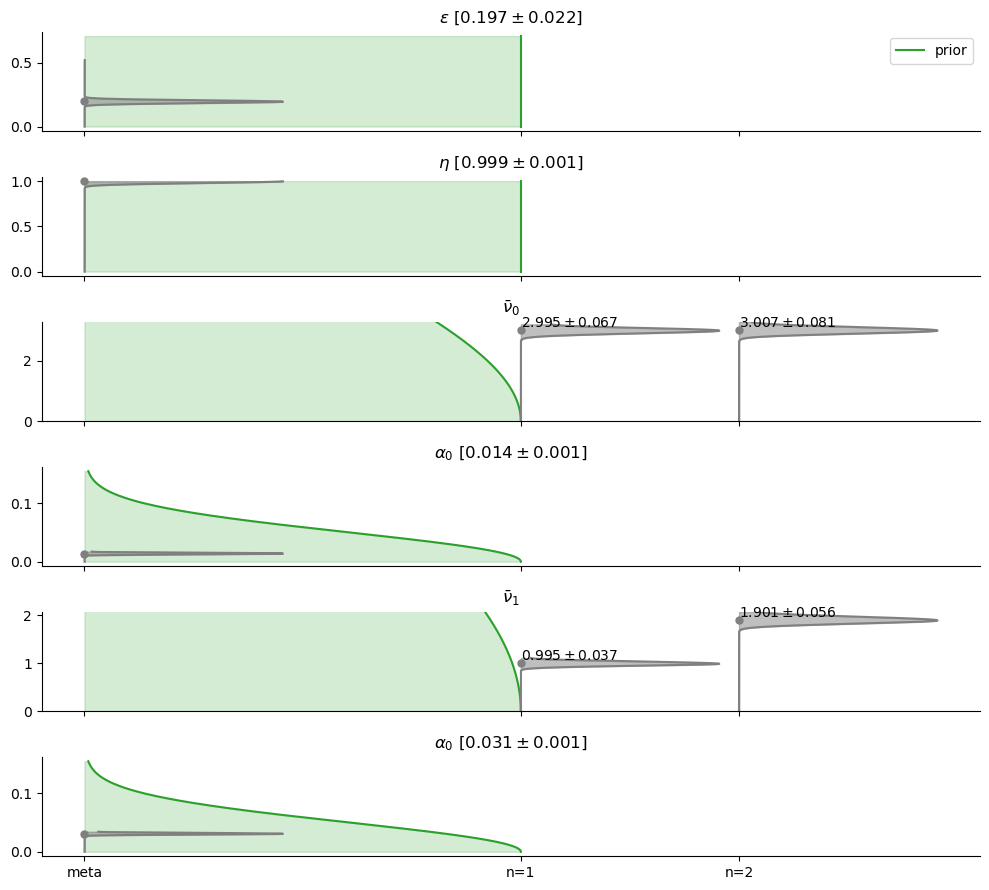

In [ ]:
SD,BM,results,sampler = run_with_conditions(ground_truth_params, [1.,2.])

In [44]:
conditions = [1.,2.]

gtp = copy.deepcopy(ground_truth_params)
truths = build_truths(gtp, conditions={"nu_bar_pop1": conditions})

N = 1000; T = 120
event_counts = np.zeros((len(conditions),2,N))
for i, nu in enumerate(conditions):
    gtp["distr"][1]["nu_bar"] = nu
    SD,net = create_data_from_params(gtp,N=N,T=T)
    event_counts[i,...] = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])

BM = BayesModel()  # logLevel=logging.WARNING)
BM.prepare_data(event_counts, T=T)
BM.set_priors(prior)
prior_transformation = BM.set_prior_transform(vectorized=False)
loglikelihood = BM.set_logl(
    vectorized=False,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=True,
)

p_in = np.random.uniform(0, 1, size=(BM.n_params,))
pprint.pprint(p_in)

p_trafo = prior_transformation(p_in)
loglikelihood(p_trafo)

Different values of kappa currently not possible - check what needs to be done!
array([0.17404141, 0.05930193, 0.27800431, 0.58018522, 0.0232128 ,
       0.52383089, 0.41738488, 0.2830757 ])
set params:
eps 0.12306586262199498
eps None None
set params:
eta 0.059301934692350344
eta None None
set params:
nu_bar_pop0 1.7789643586347732
nu_bar 0 None
set params:
alpha_0_pop0 0.0014548514813089463
alpha_0 0 None
set params:
tau_I_s0_pop0 0.005
tau_I 0 0
set params:
nu_bar_pop1 3.5623877163430078
nu_bar 1 None
set params:
alpha_0_pop1 0.018128622338972642
alpha_0 1 None
set params:
tau_I_s0_pop1 0.001
tau_I 1 0
set params:
eps 0.12306586262199498
eps None None
set params:
eta 0.059301934692350344
eta None None
set params:
nu_bar_pop0 4.0337131361269885
nu_bar 0 None
set params:
alpha_0_pop0 0.0014548514813089463
alpha_0 0 None
set params:
tau_I_s0_pop0 0.005
tau_I 0 0
set params:
nu_bar_pop1 2.747844323546302
nu_bar 1 None
set params:
alpha_0_pop1 0.018128622338972642
alpha_0 1 None
set para

np.float64(-2000000.0)

{'eps': 0.5, 'eta': 0.7, 'nu_bar_pop0': 3.0, 'alpha_0_pop0': 0.01, 'tau_I_s0_pop0': 0.005, 'nu_bar_pop1': [1.0, 2.0], 'alpha_0_pop1': 0.03, 'tau_I_s0_pop1': 0.001}


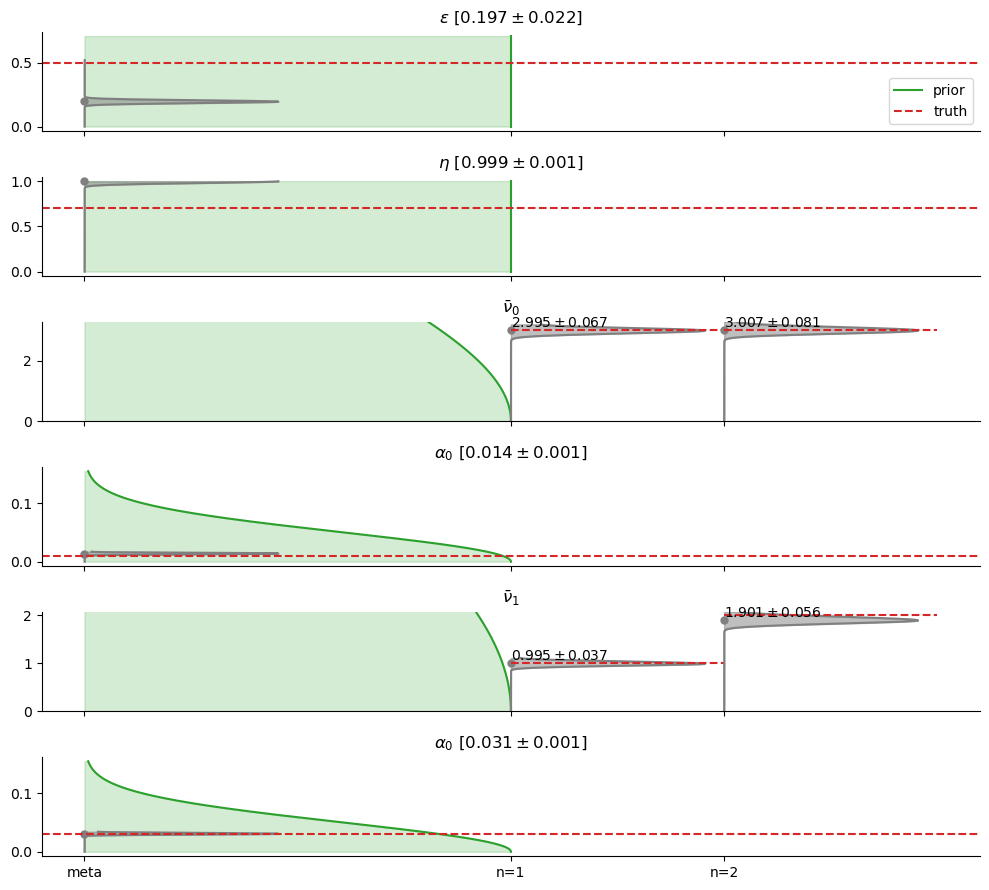

In [42]:
truths = build_truths(ground_truth_params, conditions={"nu_bar_pop1": [1.,2.]})
print(truths)
plot_results(BM,results, mode="dynesty",truths=truths)

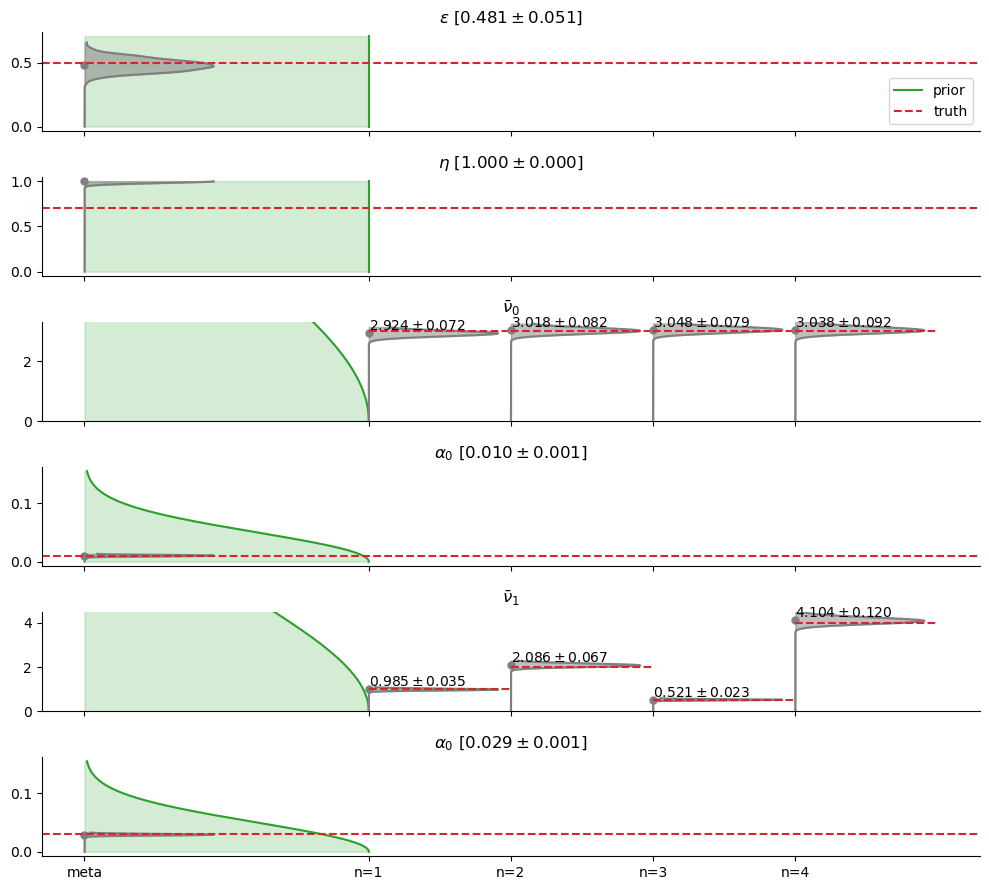

self.n_pop=2


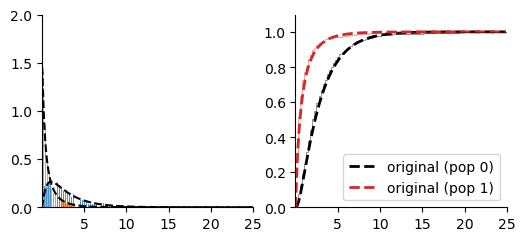

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


1534it [00:10, 140.07it/s, +100 | bound: 29 | nc: 1 | ncall: 80315 | eff(%):  2.037 | loglstar:   -inf < -2068.049 <    inf | logz: -2083.694 +/-  0.375 | dlogz:  0.013 >  1.000]


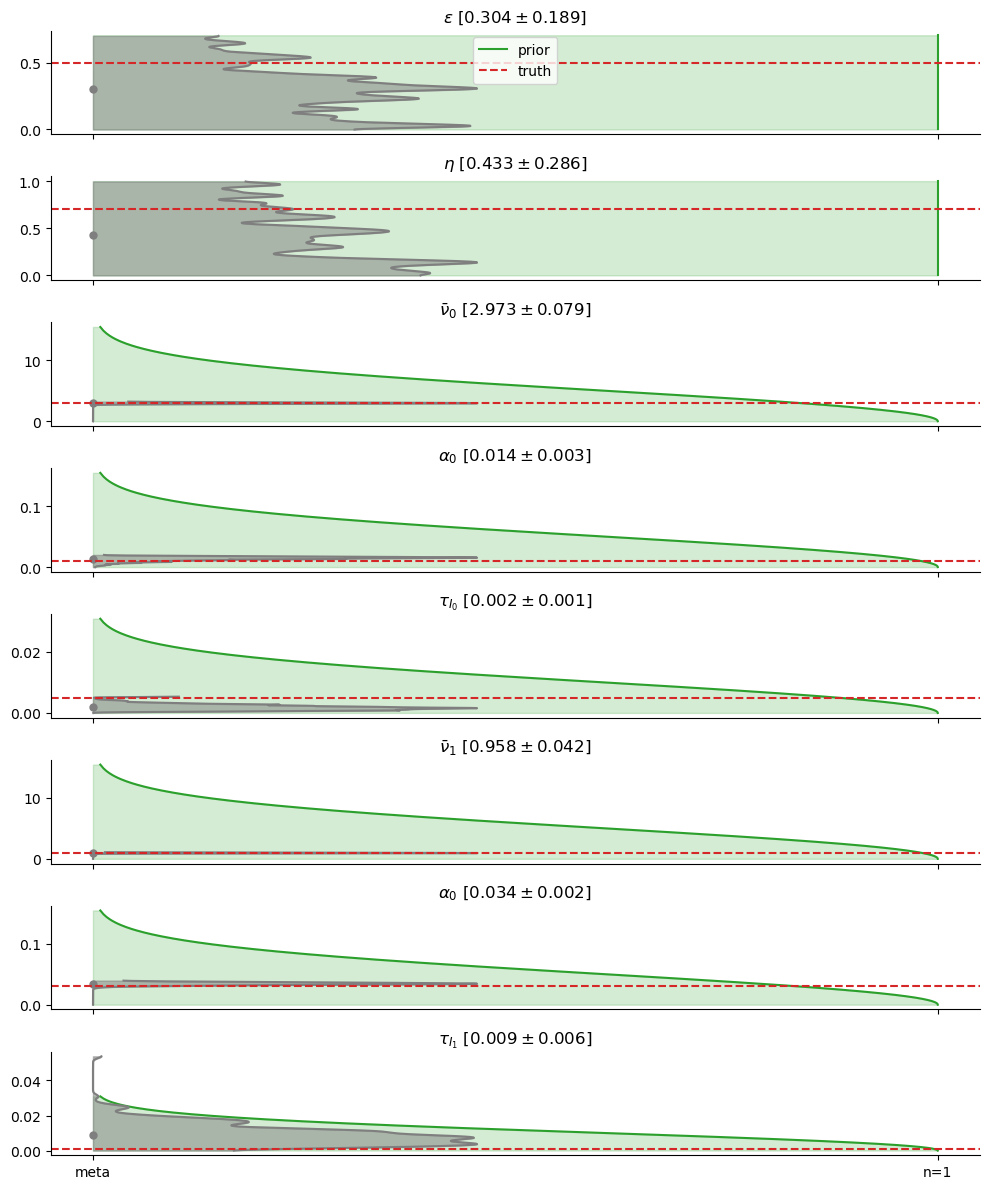

In [ ]:
ground_truth_params = {
    "eps": 0.5,
    "eta": 0.7,
    "distr": [
        {
            "nu_bar": 3., 
            "alpha_0": 0.01, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.03, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.001}
            ],
        },
    ],
}
# nu_conditions = [1.]

truths = {}
for key in ["eps","eta"]:
    truths[key] = ground_truth_params[key]
for p,pop in enumerate(ground_truth_params["distr"]):
    for key in ["nu_bar","alpha_0"]:
        truths[f"{key}_pop{p}"] = pop[key]

    for s,syn in enumerate(pop["synapses"]):
        for key in ["tau_I"]:
            truths[f"{key}_s{s}_pop{p}"] = syn[key]
# truths["nu_bar_pop1"] = nu_conditions  # for all conditions

N = 1000; T = 120
SD,net = create_data_from_params(ground_truth_params,N=N,T=T)
event_counts = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])
prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)

plot_results(BM,results, mode="dynesty",truths=truths)


self.n_pop=2


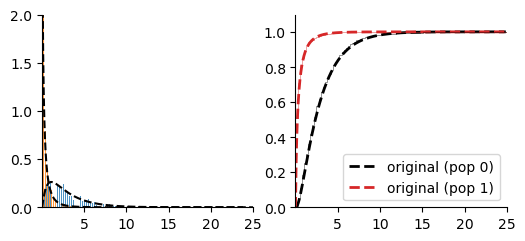

self.n_pop=2


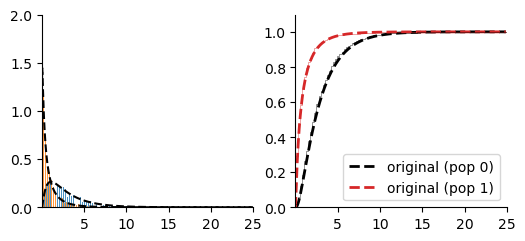

self.n_pop=2


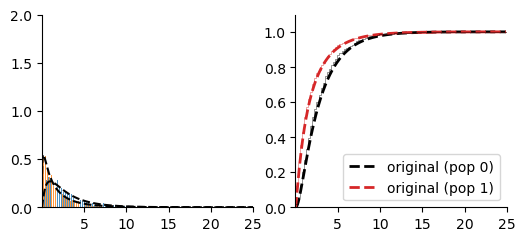

self.n_pop=2


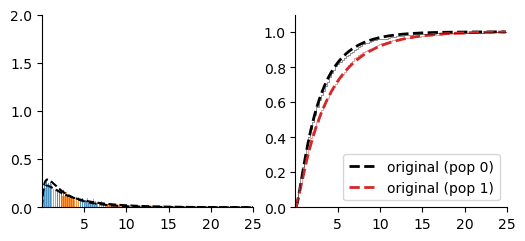

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


3751it [02:14, 27.94it/s, +100 | bound: 83 | nc: 1 | ncall: 283333 | eff(%):  1.360 | loglstar:   -inf < -9177.131 <    inf | logz: -9214.792 +/-  0.629 | dlogz:  0.012 >  1.000]


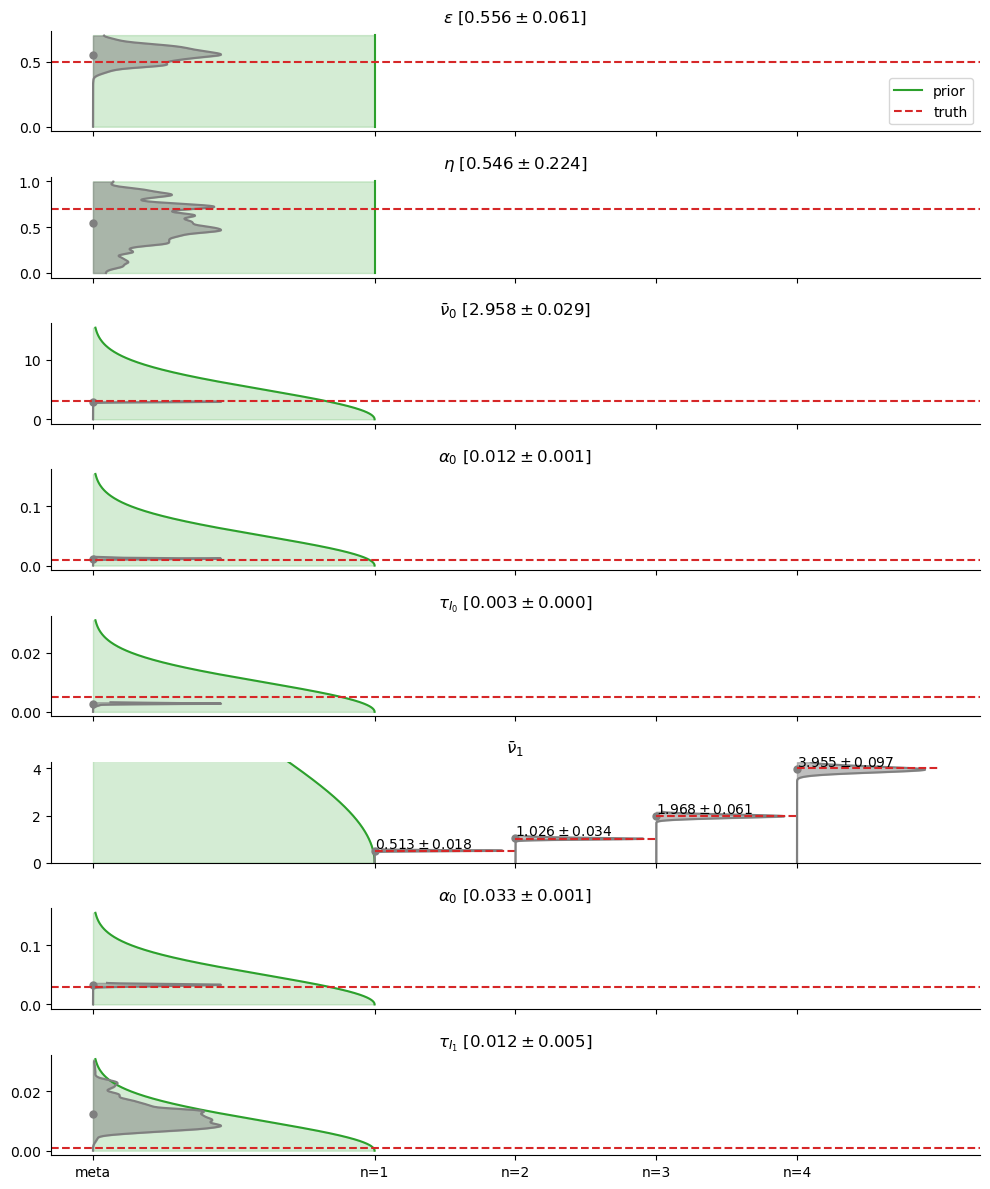

In [18]:
ground_truth_params = {
    "eps": 0.5,
    "eta": 0.7,
    "distr": [
        {
            "nu_bar": 3., 
            "alpha_0": 0.01, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.03, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.001}
            ],
        },
    ],
}
nu_conditions = [0.5, 1., 2., 4.]

truths = {}
for key in ["eps","eta"]:
    truths[key] = ground_truth_params[key]
for p,pop in enumerate(ground_truth_params["distr"]):
    for key in ["nu_bar","alpha_0"]:
        truths[f"{key}_pop{p}"] = pop[key]

    for s,syn in enumerate(pop["synapses"]):
        for key in ["tau_I"]:
            truths[f"{key}_s{s}_pop{p}"] = syn[key]
truths["nu_bar_pop1"] = nu_conditions  # for all conditions

N = 1000; T = 120
event_counts = np.zeros((len(nu_conditions),2,N))
for i, nu in enumerate(nu_conditions):
    ground_truth_params["distr"][1]["nu_bar"] = nu
    SD,net = create_data_from_params(ground_truth_params,N=N,T=T)
    event_counts[i,...] = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])
prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)

plot_results(BM,results, mode="dynesty",truths=truths)


In [ ]:
"""
why is it not converging nicely?

tau_I -> nu_max direct connection, not adding anything new per condition!
-> +4 params per condition (gamma x2, delta x2)

-> biological parameters a bit more sophisticated: 
- eta, eps, nu_bar_0, nu_bar_1, I_ext_0, I_ext_1 
    - form cluster of 4 independent variables (each nu defined by 4 params)
    - jointly define 5th & 6th if given
    - only eps, eta remain constant across conditions
    -> 2 free params

- additional 2 free parameters alpha_0_0 and alpha_0_1

Thus: 
    4 free parameters per condition 
    + 2 constant (eps, eta) 
    + 2 kinda independent (tau_I_x)

parameters (iff 3 params free above):
    biological vs meta (excl. nu_max) // meta (incl. nu_max) 
    1 cond.: 9 vs 6  // 6
    2 cond.: 14 vs 10 // 12
    3 cond.: 19 vs 14 // 18
    *4 cond.: 24 vs 18 // 24 <- here, eta gets defined!!!
    
parameters (iff 2 params free above):
    biological vs meta (excl. nu_max) // meta (incl. nu_max) 
    1 cond.: 8 vs 6  // 6
    2 cond.: 12 vs 10 // 12 <- here should be sufficient
    3 cond.: 16 vs 14 // 18
    *4 cond.: 20 vs 18 // 24 <- here, eta gets defined!!!

    
In two population case, nu_max doesnt solely depend on tau!!

Remainder indefinite stuff due to bad inferrence of nu_max??
try fixed tau_I?!
"""

In [33]:
n_animals = SD.n_animals
n_pop = SD.n_pop
print(f"{n_animals=}, {n_pop=}")

prior = {}
for p in range(n_pop):
    prior[f"gamma_pop{p}"] = prior_structure(
        norm_ppf,
        mean=prior_structure(halfnorm_ppf, loc=1.0, scale=1.0),
        sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.2),
        # halfnorm_ppf, loc=1.0, scale=1.0,
        shape=(n_animals,),
        label=f"$\gamma_{p}$"
    )
    prior[f"delta_pop{p}"] = prior_structure(
        norm_ppf,
        mean=prior_structure(norm_ppf, mean=6.0, sigma=2.),
        sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.2),
        # norm_ppf, mean=6.0, sigma=2.,
        shape=(n_animals,),
        label=f"$\delta_{p}$",
    )
    prior[f"nu_max_pop{p}"] = prior_structure(
        # None, value=25.0,
        norm_ppf, mean=30.0, sigma=5.0,
        shape=(1,), 
        label="$\\nu^{max}_{"+str(p)+"}$"
    )

n_animals=3, n_pop=2


# Run inference
* stack event_counts of different conditions in array
* run inference on biological parameters with eps, eta, tau constant (make sure, proper calculation exists, maybe without root finding?!)
* check for convergence for 1, 2, 3 conditions

Different values of kappa currently not possible - check what needs to be done!


running nested sampling


2976it [01:04, 46.29it/s, +100 | bound: 61 | nc: 1 | ncall: 377184 | eff(%):  0.816 | loglstar:   -inf < -6954.247 <    inf | logz: -6984.098 +/-  0.557 | dlogz:  0.010 >  1.000]


Multi-population model
Multi-population model
Single population model
Multi-population model
Multi-population model
Single population model


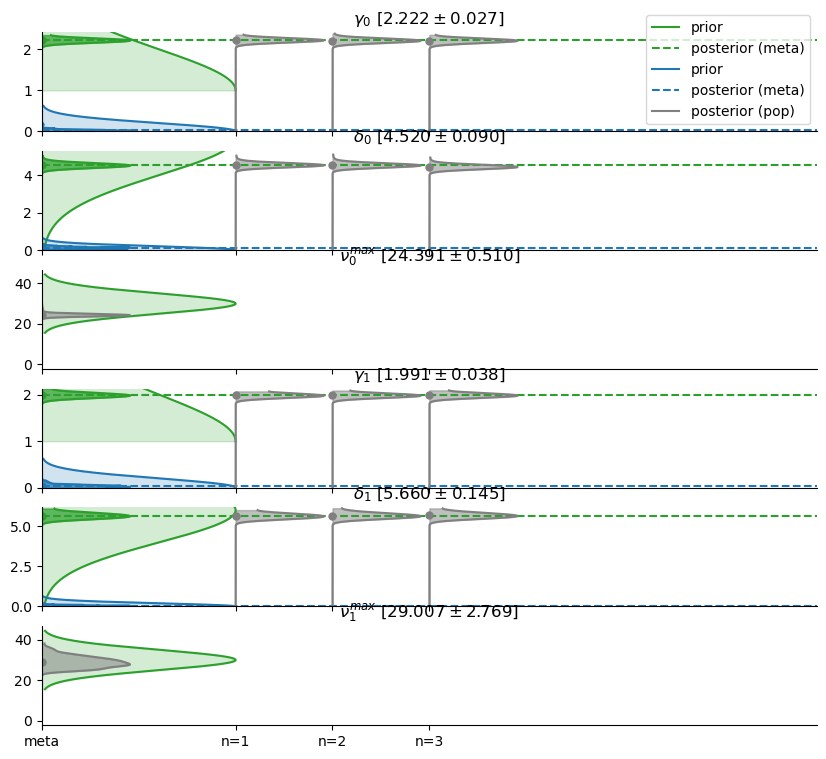

In [41]:
from inference.NestedSamplingMethods import run_sampling, plot_results
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)
plot_results(BM,results, mode="dynesty")

In [42]:
BM = BayesModel()  # logLevel=logging.WARNING)
BM.prepare_data(SD.event_counts, T=ref_values["T"])
BM.set_priors(prior)
prior_transformation = BM.set_prior_transform(vectorized=False)
loglikelihood = BM.set_logl(
    vectorized=False,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=True,
)

Different values of kappa currently not possible - check what needs to be done!


running nested sampling


2626it [01:16, 34.15it/s, +100 | bound: 59 | nc: 1 | ncall: 263921 | eff(%):  1.033 | loglstar:   -inf < -6917.585 <    inf | logz: -6944.050 +/-  0.523 | dlogz:  0.011 >  1.000]


Single population model
Single population model
Multi-population model
Single population model
Single population model
Multi-population model
Single population model
Single population model


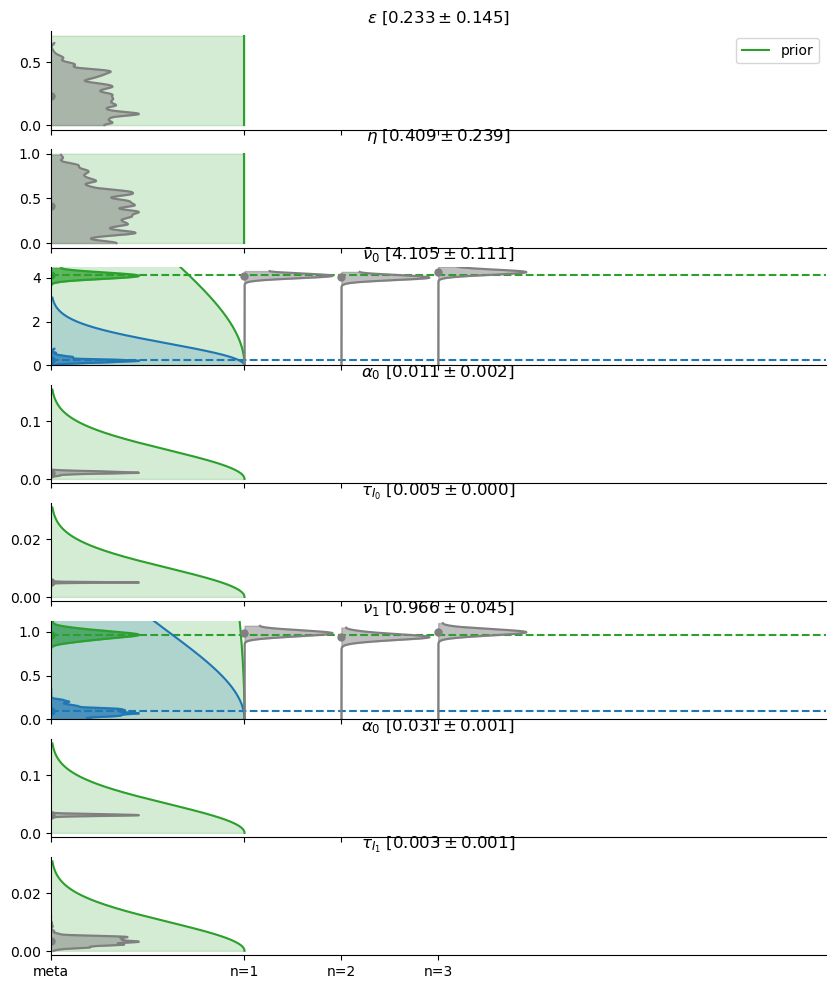

In [43]:
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)
plot_results(BM,results, mode="dynesty")

Single population model
Single population model
Multi-population model
Single population model
Single population model
Multi-population model
Single population model
Single population model


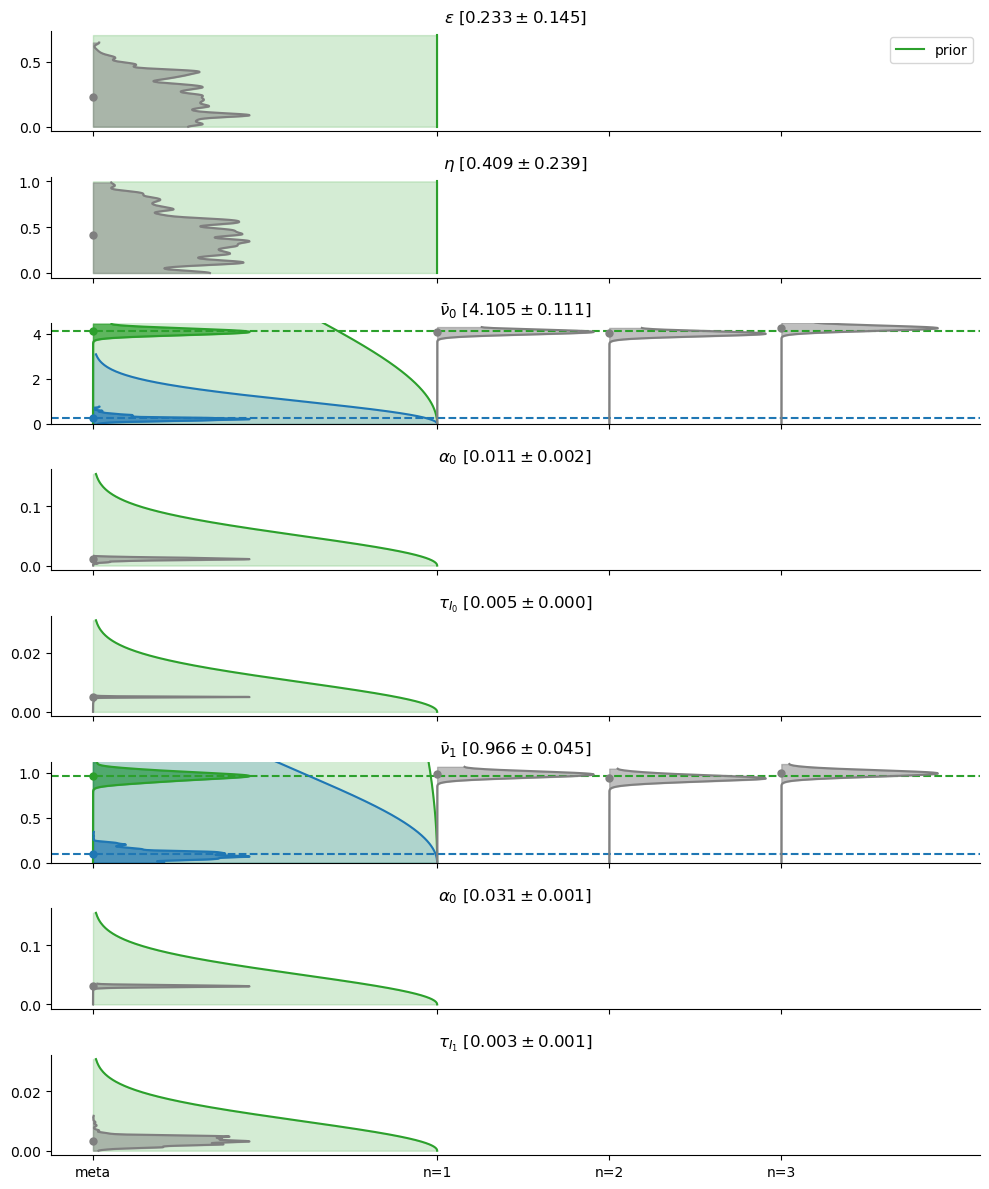

In [47]:
plot_results(BM,results, mode="dynesty")

In [46]:
BM.dimensions

{'shape': (3, 2, 1000),
 'shape_iter': (3,),
 'n': 3,
 'n_iter': 3,
 'names': ['dimension_0_x3', 'dimension_1_x2', 'dimension_2_x1000'],
 'iterator': [(0,), (1,), (2,)],
 'n_pop': 2}

In [35]:
p_in = np.random.uniform(0, 1, size=(BM.n_params,))
pprint.pprint(p_in)

p_trafo = prior_transformation(p_in)
loglikelihood(p_trafo)

array([0.92993881, 0.85964923, 0.99879286, 0.59323352, 0.18788773,
       0.88267762, 0.97346208, 0.00548251, 0.1102791 , 0.5458995 ,
       0.92601658, 0.47202086, 0.35433552, 0.81610884, 0.00298964,
       0.32735471, 0.77441646, 0.27839873, 0.57839672, 0.24620124,
       0.18317774, 0.77885796])


np.float64(-3000000.0)

In [39]:
ref_values["distr"]

[DistributionModelParams(gamma=np.float64(2.2190919039959582), delta=np.float64(4.528616280164686), nu_max=np.float64(24.768718291424488), kappa=1.0),
 DistributionModelParams(gamma=np.float64(1.9653734780408834), delta=np.float64(5.535170982193302), nu_max=np.float64(26.191581638761477), kappa=1.0)]

In [13]:
%timeit my_likelihood(p_trafo)

7.49 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
from inference.BayesModel import run_sampling
BM, res, sampler = run_sampling(
    mP.spike_counts.T,
    mP.T,
    prior,
    mode="dynesty",
    n_live=100,
    correct_N=0,
    bias_to_expected_max=0,
    nP=12,
    biological=True
)

running nested sampling


1768it [00:35, 49.29it/s, +100 | bound: 35 | nc: 1 | ncall: 114325 | eff(%):  1.635 | loglstar:   -inf < -825.782 <    inf | logz: -843.476 +/-  0.439 | dlogz:  0.011 >  1.000]


In [89]:
BM.dimensions

{'shape': (6, 50),
 'n': 2,
 'names': ['dimension_0_x6', 'dimension_1_x50'],
 'iterator': [(0,), (1,), (2,), (3,), (4,), (5,)]}

Multi-population model
Single population model
Single population model


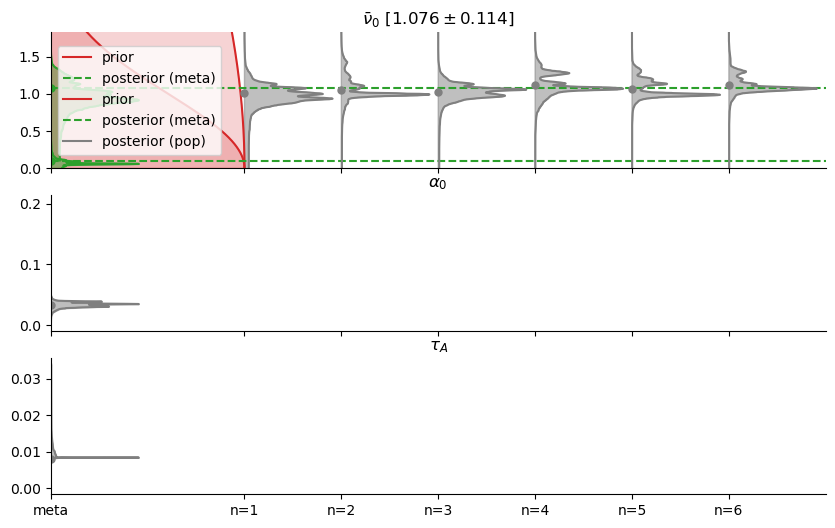

In [90]:
from inference.BayesModel import compare_results, plot_results
# sampler.results
# compare_results(BM, sampler, mP, mode='dynesty')

plot_results(BM,res, mode="dynesty")

In [13]:
from DM_theory.functions import get_gamma, get_delta, get_nu_max


def get_meta(p_bio):
    params = {}
    params["gamma"] = get_gamma(**p_bio)
    params["delta"] = get_delta(**p_bio)
    params["nu_max"] = get_nu_max(**{key:val for key,val in p_bio.items() if key not in ["alpha_0"]})
    return params

values = {
    "distr": [get_meta(p_bio)]
}
# params = get_meta(p_bio)
values

{'distr': [{'gamma': np.float64(2.349963000613782),
   'delta': np.float64(6.287589766003657),
   'nu_max': np.float64(22.507907903927652)}]}

In [52]:
from empirical.create_surrogate_data import SurrogateData, calculate_biological_parameters_from_meta
# ref = {"gamma": 1.5, "delta": 4.5, "nu_max": 25.0}

# calculate_biological_parameters_from_meta(ref_values["distr"])
# calculate_biological_parameters_from_meta([params])
p_bio = {
    "nu_bar": np.nan,
    "alpha_0": 0.02,
    "tau_A": 0.005,
    "tau_N": 0.2,
    "r_N": 0.0
}

nu_vals = [0.5,1.,2.]

SD = SurrogateData(N=1000,T=1200,n_animals=1)
event_counts = np.zeros((len(nu_vals), SD.N))
for i, nu in enumerate(nu_vals):

    p_bio["nu_bar"] = nu

    values = {
        "distr": [get_meta(p_bio)]
    }
    event_counts[i, :] = SD.artificial_data(values, plot=False)

input parameters: gamma=1.8463682139406767, delta=5.695323029991212, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(0.49999999999999967)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01971982]])], 
input parameters: gamma=2.349963000613782, delta=6.287589766003657, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(1.0000000000000004)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01941878]])], 
input parameters: gamma=2.537044422065096, delta=5.910150128836054, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(1.9999999999999996)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01820313]])], 


In [53]:
n_animals = event_counts.shape[0]
prior = {}
prior["nu_bar_pop0"] = prior_structure(
    halfnorm_ppf,
    loc=0.,
    scale=1.,
    # norm_ppf,
    # mean=prior_structure(halfnorm_ppf, loc=0.0, scale=5.0),
    # sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=1.),
    shape=(n_animals,),
    label="$\\bar{\\nu}_0$"
)
prior["alpha_0_pop0"] = prior_structure(
    # halfnorm_ppf,
    # loc=0.0,
    # scale=0.05,
    norm_ppf,
    mean=prior_structure(halfnorm_ppf, loc=0.0, scale=0.05),
    sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.005),
    shape=(n_animals,),
    label="$\\alpha_0$"
)


prior["tau_A_pop0"] = prior_structure(
    # halfnorm_ppf,
    # loc=0.0,
    # scale=0.01,
    norm_ppf,
    mean=prior_structure(halfnorm_ppf, loc=0.0,scale=0.01),
    sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.001),
    shape=(n_animals,),
    label="$\\tau_A$"
)
prior["tau_N_pop0"] = prior_structure(None, value=0.2)
prior["r_N_pop0"] = prior_structure(None, value=0)

In [54]:
from inference.BayesModel import run_sampling
BM, res, sampler = run_sampling(
    event_counts,
    SD.T,
    prior,
    mode="dynesty",
    n_live=100,
    correct_N=0,
    bias_to_expected_max=0,
    nP=12,
    biological=True
)

running nested sampling


1775it [01:22, 21.63it/s, +100 | bound: 31 | nc: 1 | ncall: 129526 | eff(%):  1.449 | loglstar:   -inf < -6909.032 <    inf | logz: -6926.775 +/-  0.439 | dlogz:  0.011 >  1.000]


Multi-population model
Multi-population model
Multi-population model


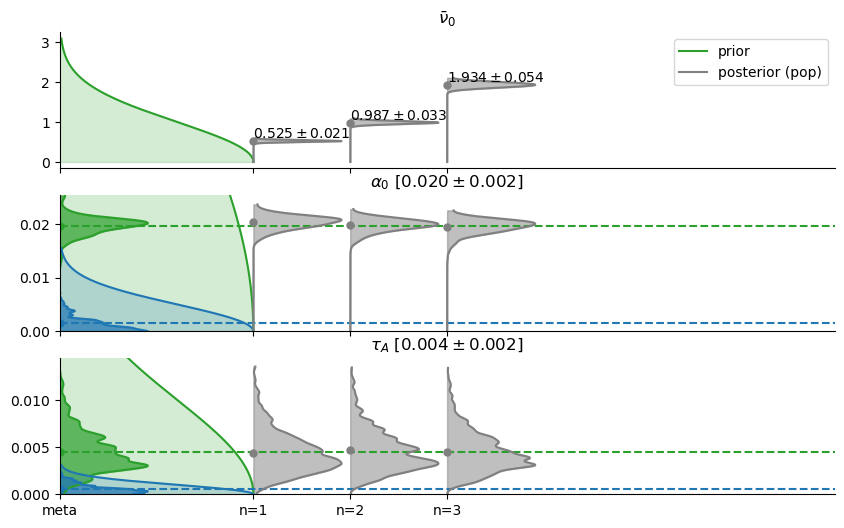

In [108]:
from inference.BayesModel import compare_results, plot_results
plot_results(BM,res, mode="dynesty")

(<Figure size 2860x2860 with 169 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='$x_{2}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{3}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{4}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{5}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{6}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <A

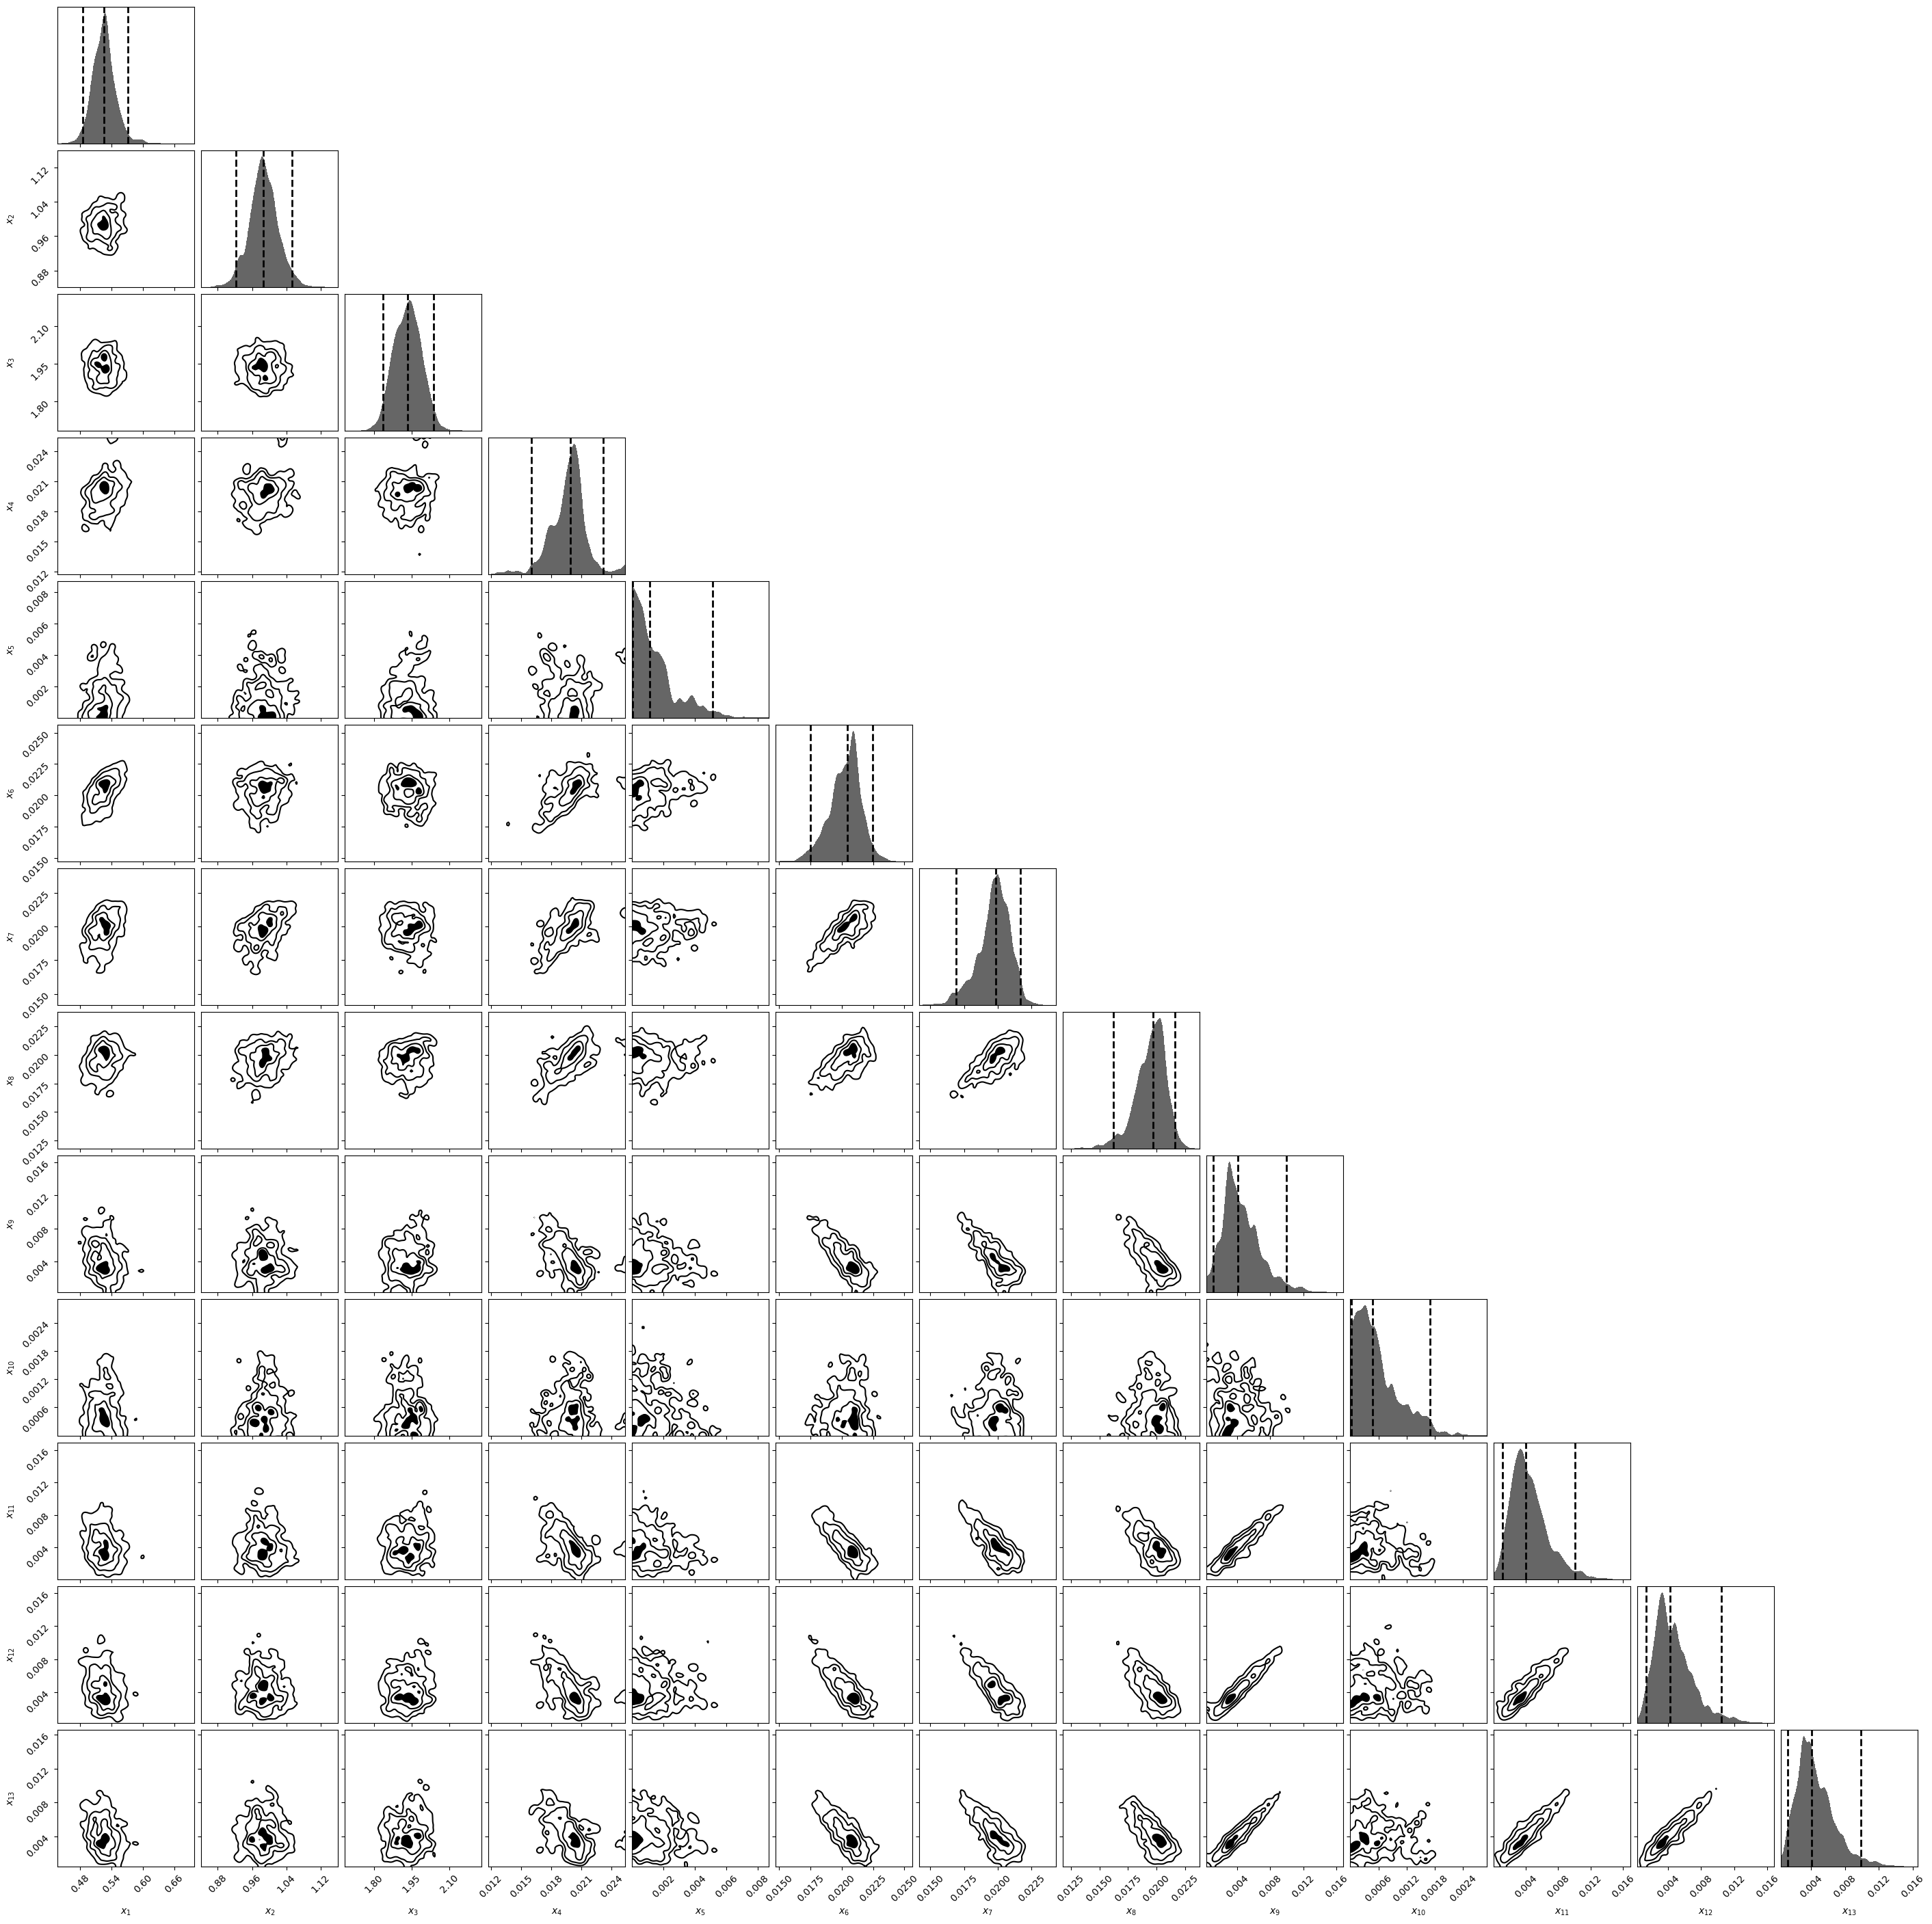

In [62]:
from dynesty import utils as dyfunc, plotting as dyplot

dyplot.cornerplot(sampler.results)